In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
import librosa

In [2]:
# import data from CAR01, a chervolet spark idleing at around 800 RPM
sample_rate, data_NORMAL = wavfile.read('C:\\Users\\nusse\\Desktop\\EH5TinyML\\soundovertcp\\Server\\out\\NORMAL\\CAR01_NORMAL2.wav')
sample_rate, data_FAULTY = wavfile.read('C:\\Users\\nusse\\Desktop\\EH5TinyML\\soundovertcp\\Server\\out\\FAULTY\\CAR01_FAULTY2.wav')
print(f'Sample Rate: {sample_rate/1000} kHz')
print(f'Data NORMAL Shape: {data_NORMAL.shape}')
print(f'Data FAULTY Shape: {data_FAULTY.shape}')

Sample Rate: 16.0 kHz
Data NORMAL Shape: (1920768,)
Data FAULTY Shape: (1920768,)


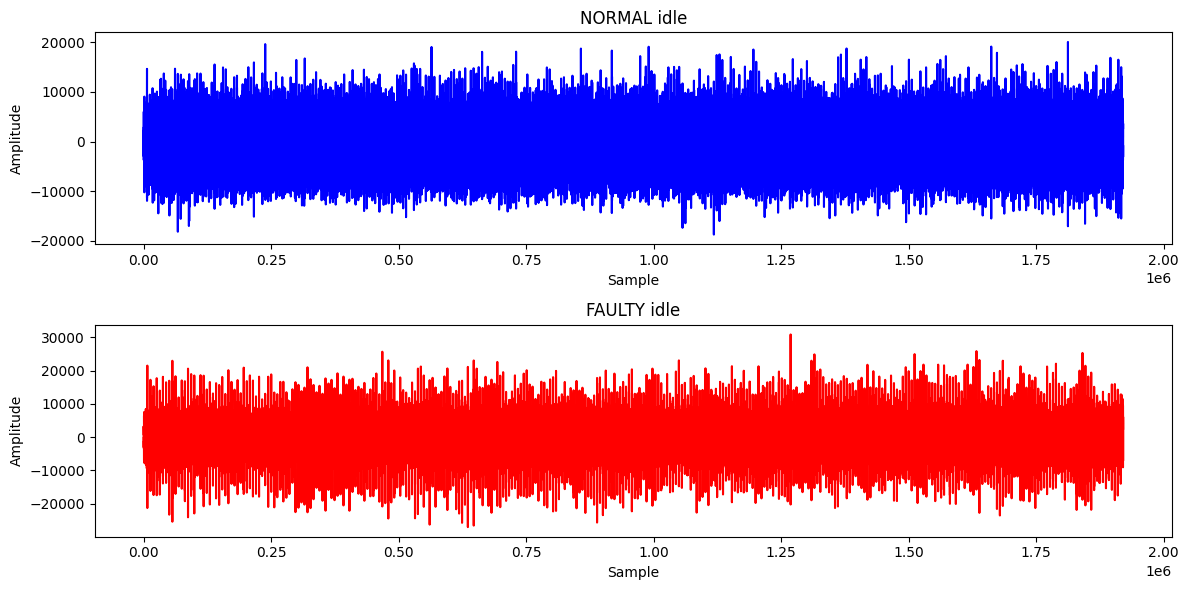

Energy of NORMAL idle signal: 4514715.384646142
Energy of FAULTY idle signal: 4874304.503531921


In [3]:
# plot the data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(data_NORMAL, color='blue')
plt.title('NORMAL idle')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.subplot(2, 1, 2)
plt.plot(data_FAULTY, color='red')
plt.title('FAULTY idle')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()
# Calculate energy of the signals
energy_NORMAL = np.sum(data_NORMAL.astype(float)**2) / len(data_NORMAL)
energy_FAULTY = np.sum(data_FAULTY.astype(float)**2) / len(data_FAULTY)
print(f'Energy of NORMAL idle signal: {energy_NORMAL}')
print(f'Energy of FAULTY idle signal: {energy_FAULTY}')

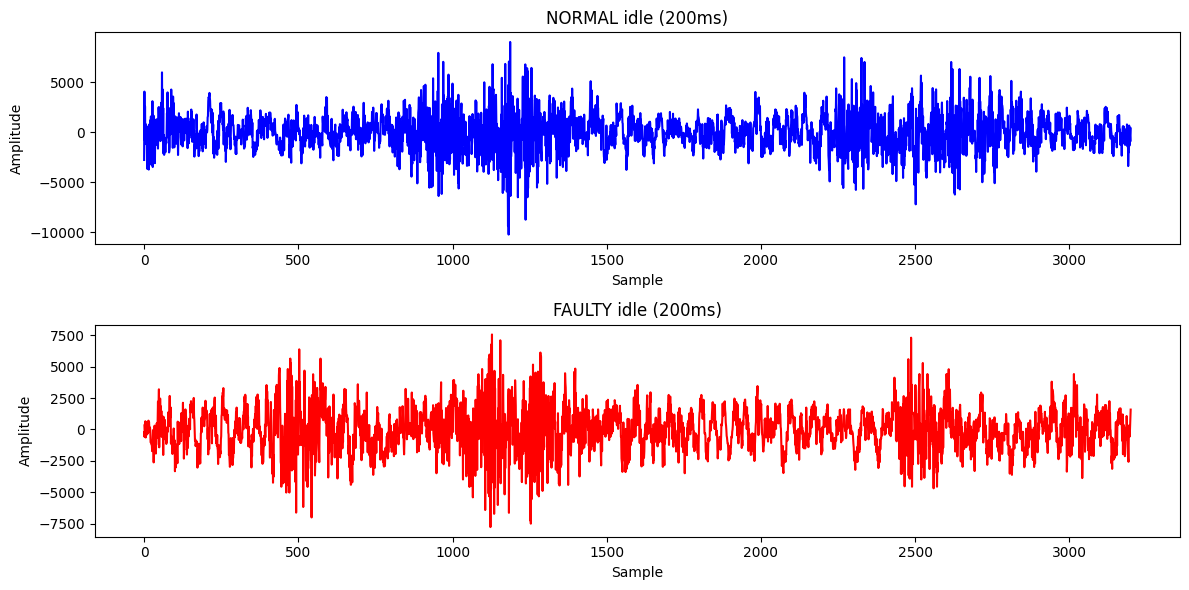

In [4]:
# The car engine has 4 cylinders and idles at around 800 RPM
# Ignition occurs somewhere in the engine every 180 degrees of rotation
# one cylinder will fire very 720 degrees - 2 rotations
# thus at 800 RPM, one cylinder fires around 6.67 times per second
# 4 cylinders means 26.67 ignitions per second
# the ignition frequency is around 26.67 Hz or every 37.5 ms, 4* 37.5ms = 150ms for all cylinders to fire
# plotting 200ms of data to capture all cylinders firing
ms200 = int(0.2 * sample_rate)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(data_NORMAL[:ms200], color='blue')
plt.title('NORMAL idle (200ms)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.subplot(2, 1, 2)
plt.plot(data_FAULTY[:ms200], color='red')
plt.title('FAULTY idle (200ms)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [5]:
# energy
env1 = np.abs(data_NORMAL)
env2 = np.abs(data_FAULTY)
from scipy.signal import find_peaks
# moving average for smoothing
env1_smooth = np.convolve(env1, np.ones(2000)/2000, mode='same')
env2_smooth = np.convolve(env2, np.ones(2000)/2000, mode='same')

# Find peaks
peaks1, _ = find_peaks(env1_smooth, distance=sample_rate*0.02)  # mindst 20 ms mellem tændinger
peaks2, _ = find_peaks(env2_smooth, distance=sample_rate*0.02)

# average period between ignitions
period1 = np.mean(np.diff(peaks1)) / sample_rate
period2 = np.mean(np.diff(peaks2)) / sample_rate

print(f"Normal:  {1/period1:.1f} ignitions per second")
print(f"Faulty:  {1/period2:.1f} ignitions per second")

Normal:  44.9 ignitions per second
Faulty:  43.9 ignitions per second


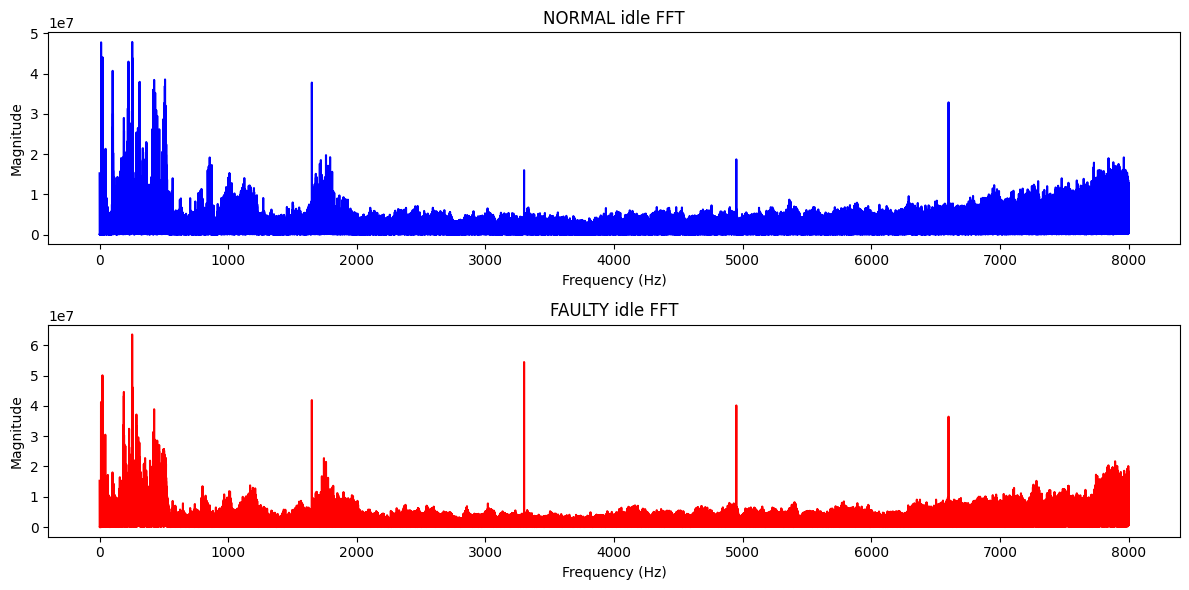

In [6]:
# FFT analysis
fft_NORMAL = np.fft.fft(data_NORMAL)
fft_FAULTY = np.fft.fft(data_FAULTY)
freqs = np.fft.fftfreq(len(fft_NORMAL), 1/sample_rate)
magnitude_NORMAL = np.abs(fft_NORMAL)
magnitude_FAULTY = np.abs(fft_FAULTY)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(freqs[:len(freqs)//2], magnitude_NORMAL[:len(magnitude_NORMAL)//2], color='blue')
plt.title('NORMAL idle FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.subplot(2, 1, 2)
plt.plot(freqs[:len(freqs)//2], magnitude_FAULTY[:len(magnitude_FAULTY)//2], color='red')
plt.title('FAULTY idle FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

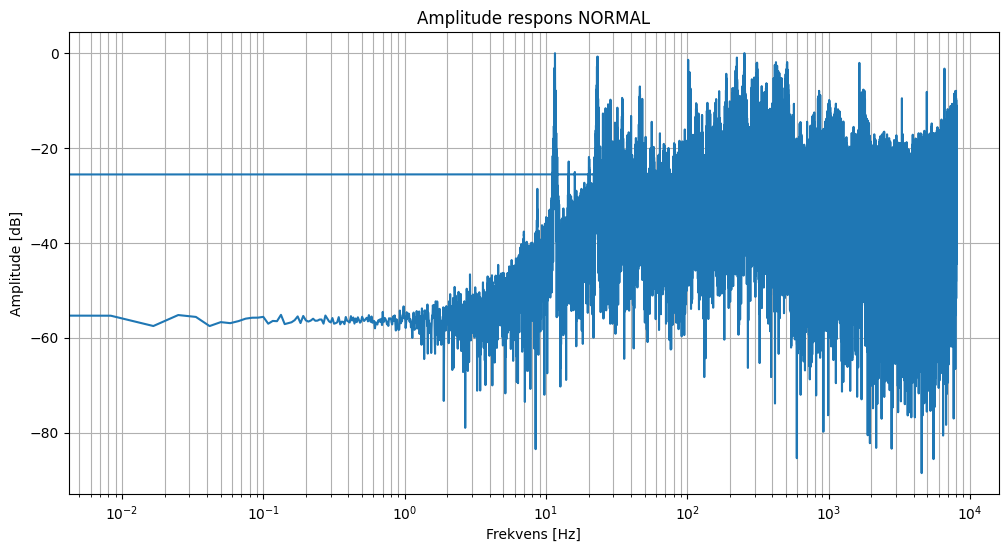

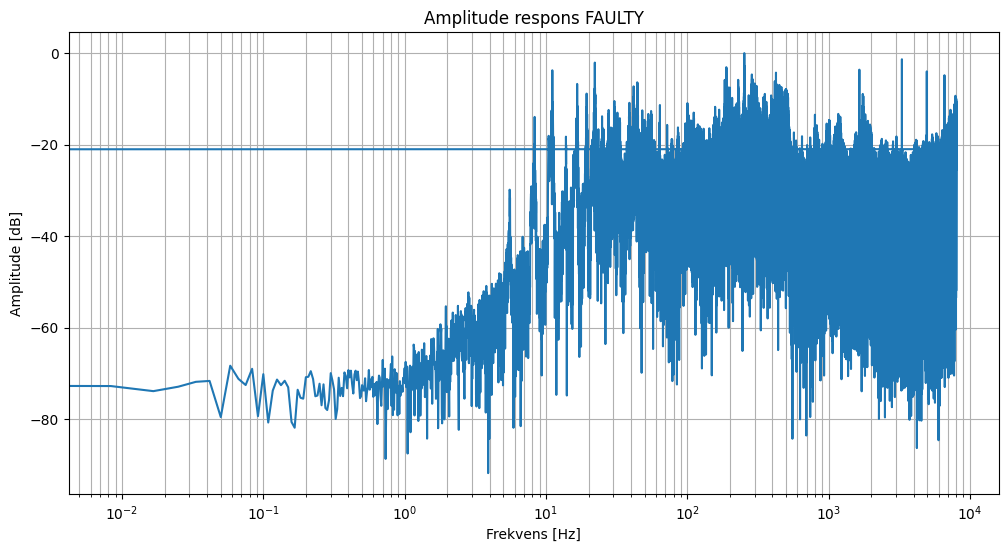

In [ ]:
# Amplitude respons, DB scale, semilogx
plt.figure(figsize=(12, 6))
plt.semilogx(freqs, 20*np.log10(magnitude_NORMAL / np.max(magnitude_NORMAL)))
plt.title("Amplitude respons NORMAL")
plt.xlabel("Frekvens [Hz]")
plt.ylabel("Amplitude [dB]")
plt.grid(True, which='both')
plt.show()

plt.figure(figsize=(12, 6))
plt.semilogx(freqs, 20*np.log10(magnitude_FAULTY / np.max(magnitude_FAULTY)))
plt.title("Amplitude respons FAULTY")
plt.xlabel("Frekvens [Hz]")
plt.ylabel("Amplitude [dB]")
plt.grid(True, which='both')
plt.show()

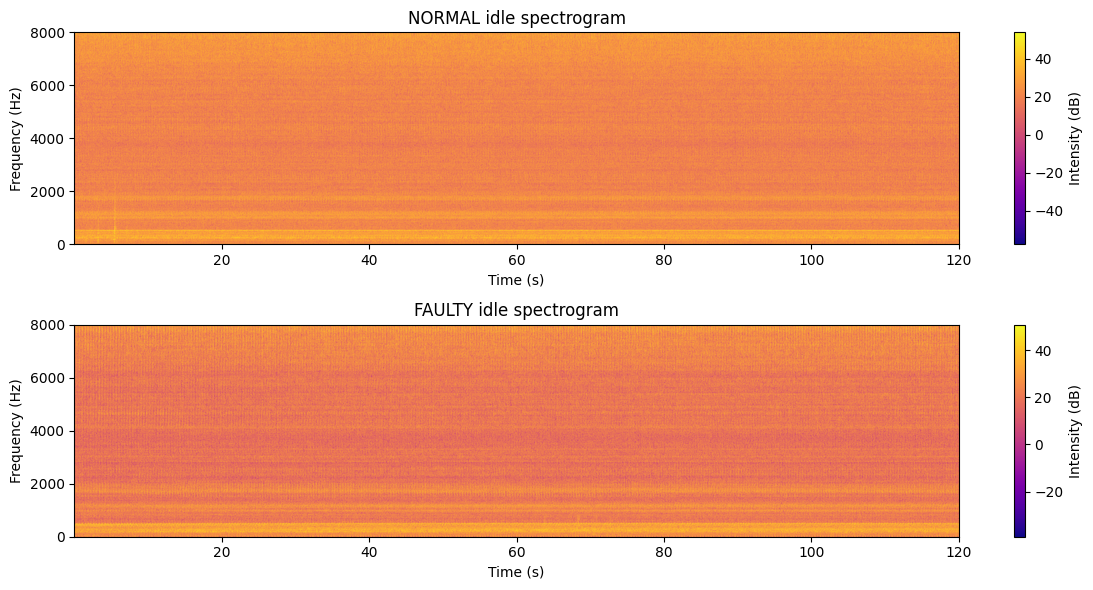

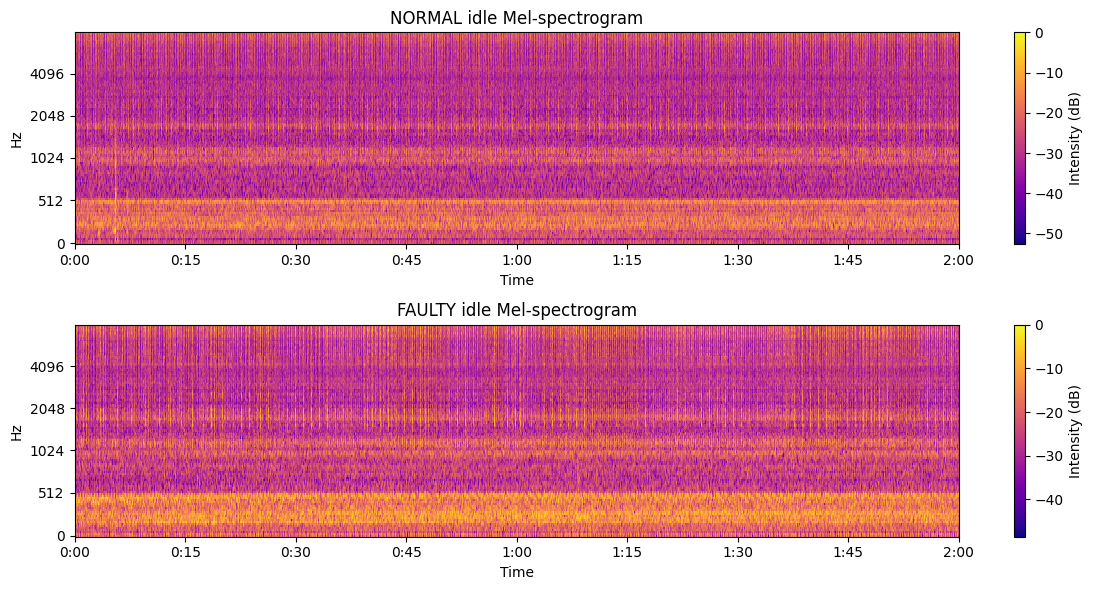

In [8]:
# spectrogram analysis
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.specgram(data_NORMAL, Fs=sample_rate, NFFT=1024, noverlap=512, cmap='plasma')
plt.title('NORMAL idle spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)')
plt.subplot(2, 1, 2)
plt.specgram(data_FAULTY, Fs=sample_rate, NFFT=1024, noverlap=512, cmap='plasma')
plt.title('FAULTY idle spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)')
plt.tight_layout()
plt.show()
# Mel-spectrogram analysis
mel_NORMAL = librosa.feature.melspectrogram(y=data_NORMAL.astype(float), sr=sample_rate, n_fft=1024, hop_length=512, n_mels=128)
mel_FAULTY = librosa.feature.melspectrogram(y=data_FAULTY.astype(float), sr=sample_rate, n_fft=1024, hop_length=512, n_mels=128)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.power_to_db(mel_NORMAL, ref=np.max), sr=sample_rate, x_axis='time', y_axis='mel', cmap='plasma')
plt.title('NORMAL idle Mel-spectrogram')
plt.colorbar(label='Intensity (dB)')
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.power_to_db(mel_FAULTY, ref=np.max), sr=sample_rate, x_axis='time', y_axis='mel', cmap='plasma')
plt.title('FAULTY idle Mel-spectrogram')
plt.colorbar(label='Intensity (dB)')
plt.tight_layout()
plt.show()

In [20]:
# Low pass filter data_normal and data_faulty
from scipy.signal import butter, lfilter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
cutoff = 30  # desired cutoff frequency of the filter, Hz
fs = sample_rate  # sample rate, Hz
data_normal_filtered = lowpass_filter(data_NORMAL, cutoff, fs)
data_faulty_filtered = lowpass_filter(data_FAULTY, cutoff, fs)